# NARSAD Trial Tracking Analysis

This notebook demonstrates the **9 Interesting Contrasts** implementation for the NARSAD task using real data.

## Overview
- **9 Focused Contrasts**: Scientifically relevant comparisons only
- **"Others" Conditions**: Focus on learned responses (excluding first trials)
- **Baseline Comparisons**: CS-_others, CSS_others, CSR_others vs FIXATION
- **Between-Condition Comparisons**: Different CS types and CS+ vs CS- comparisons

## What This Notebook Does
1. **Loads real NARSAD data** from both phase2 and phase3
2. **Groups trials** into first/others categories
3. **Generates 9 interesting contrasts** using exact functions from `first_level_workflows.py`
4. **Creates contrast CSV files** for both phases
5. **Visualizes design matrices** for both phases


In [77]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import os
from matplotlib.gridspec import GridSpec

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## Load NARSAD Data

Load both phase2 and phase3 event data


In [78]:
# Load NARSAD data
behav_dir = "/Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav"
phase2_file = os.path.join(behav_dir, "task-Narsad_phase2_events.csv")
phase3_file = os.path.join(behav_dir, "task-Narsad_phase3_events.csv")

# Load phase2 data
df_phase2 = pd.read_csv(phase2_file)
print(f"Phase2: {len(df_phase2)} trials, {len(df_phase2['trial_type'].unique())} trial types")
print(f"Trial types: {sorted(df_phase2['trial_type'].unique())}")

# Load phase3 data
df_phase3 = pd.read_csv(phase3_file)
print(f"\nPhase3: {len(df_phase3)} trials, {len(df_phase3['trial_type'].unique())} trial types")
print(f"Trial types: {sorted(df_phase3['trial_type'].unique())}")

print("\n✅ Data loaded successfully")


Phase2: 63 trials, 6 trial types
Trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'US_CSR', 'US_CSS']

Phase3: 52 trials, 5 trial types
Trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'SHOCK']

✅ Data loaded successfully


## Core Functions

Exact copies from `first_level_workflows.py` (standalone version)


In [79]:
def extract_cs_conditions(df_trial_info):
    """
    Extract and group CS-, CSS, and CSR conditions from a pandas DataFrame.
    
    This function adds a 'conditions' column to the DataFrame that groups trials:
    - First trial of each CS type becomes 'CS-_first', 'CSS_first', 'CSR_first'
    - Remaining trials of each type become 'CS-_others', 'CSS_others', 'CSR_others'
    - All other trials keep their original trial_type as conditions value
    """
    # Validate DataFrame input
    if not isinstance(df_trial_info, pd.DataFrame):
        raise ValueError("df_trial_info must be a pandas DataFrame")
    
    if df_trial_info.empty:
        raise ValueError("DataFrame cannot be empty")
    
    required_columns = ['trial_type', 'onset']
    missing_columns = [col for col in required_columns if col not in df_trial_info.columns]
    if missing_columns:
        raise ValueError(f"DataFrame missing required columns: {missing_columns}")
    
    # Create a copy to avoid modifying original
    df_work = df_trial_info.copy()
    
    # Initialize conditions column with trial_type values
    df_work['conditions'] = df_work['trial_type'].copy()
    
    logger.info(f"Using DataFrame input with {len(df_work)} trials")
    
    # Find first trial of each CS type (by onset time)
    cs_trials = df_work[df_work['trial_type'].str.startswith('CS-') & 
                       ~df_work['trial_type'].str.startswith('CSS') & 
                       ~df_work['trial_type'].str.startswith('CSR')].copy()
    css_trials = df_work[df_work['trial_type'].str.startswith('CSS')].copy()
    csr_trials = df_work[df_work['trial_type'].str.startswith('CSR')].copy()
    
    # Update conditions column for CS- trials
    if not cs_trials.empty:
        cs_first_idx = cs_trials.sort_values('onset').index[0]
        df_work.loc[cs_first_idx, 'conditions'] = 'CS-_first'
        cs_other_indices = cs_trials[cs_trials.index != cs_first_idx].index
        df_work.loc[cs_other_indices, 'conditions'] = 'CS-_others'
        logger.info(f"CS- conditions: first trial at index {cs_first_idx}, {len(cs_other_indices)} others")
    
    # Update conditions column for CSS trials
    if not css_trials.empty:
        css_first_idx = css_trials.sort_values('onset').index[0]
        df_work.loc[css_first_idx, 'conditions'] = 'CSS_first'
        css_other_indices = css_trials[css_trials.index != css_first_idx].index
        df_work.loc[css_other_indices, 'conditions'] = 'CSS_others'
        logger.info(f"CSS conditions: first trial at index {css_first_idx}, {len(css_other_indices)} others")
    
    # Update conditions column for CSR trials
    if not csr_trials.empty:
        csr_first_idx = csr_trials.sort_values('onset').index[0]
        df_work.loc[csr_first_idx, 'conditions'] = 'CSR_first'
        csr_other_indices = csr_trials[csr_trials.index != csr_first_idx].index
        df_work.loc[csr_other_indices, 'conditions'] = 'CSR_others'
        logger.info(f"CSR conditions: first trial at index {csr_first_idx}, {len(csr_other_indices)} others")
    
    # Get unique conditions for contrast generation
    unique_conditions = df_work['conditions'].unique().tolist()
    logger.info(f"Unique conditions for contrast generation: {unique_conditions}")
    
    # Extract grouped conditions for backward compatibility
    cs_conditions = {'first': 'CS-_first' if 'CS-_first' in unique_conditions else None, 
                     'other': ['CS-_others'] if 'CS-_others' in unique_conditions else []}
    css_conditions = {'first': 'CSS_first' if 'CSS_first' in unique_conditions else None, 
                      'other': ['CSS_others'] if 'CSS_others' in unique_conditions else []}
    csr_conditions = {'first': 'CSR_first' if 'CSR_first' in unique_conditions else None, 
                      'other': ['CSR_others'] if 'CSR_others' in unique_conditions else []}
    
    # Get other conditions (non-CS/CSS/CSR)
    other_conditions = df_work[~df_work['trial_type'].str.startswith('CS')]['trial_type'].unique().tolist()
    
    logger.info(f"Processed conditions: CS-={cs_conditions}, CSS={css_conditions}, CSR={csr_conditions}")
    logger.info(f"Other conditions: {other_conditions}")
    
    return df_work, cs_conditions, css_conditions, csr_conditions, other_conditions

print("✅ extract_cs_conditions function defined")


✅ extract_cs_conditions function defined


In [80]:
def create_interesting_contrasts(df_trial_info):
    """
    Create only the interesting contrasts for NARSAD analysis.
    
    This function creates a focused set of contrasts that are most relevant
    for the NARSAD study, focusing on comparisons between "others" conditions
    and baseline, as well as between different "others" conditions.
    """
    if df_trial_info is None:
        raise ValueError("df_trial_info is required")
    
    # Extract CS-, CSS, and CSR conditions with grouping
    df_with_conditions, cs_conditions, css_conditions, csr_conditions, other_conditions = extract_cs_conditions(df_trial_info)
    
    # Use the conditions column for contrast generation
    all_contrast_conditions = df_with_conditions['conditions'].unique().tolist()
    
    # Define the interesting contrasts
    interesting_contrasts = [
        ("CS-_others > FIXATION", "Other CS- trials vs baseline"),
        ("CSS_others > FIXATION", "Other CSS trials vs baseline"),
        ("CSR_others > FIXATION", "Other CSR trials vs baseline"),
        ("CSS_others > CSR_others", "Other CSS trials vs Other CSR trials"),
        ("CSR_others > CSS_others", "Other CSR trials vs Other CSS trials"),
        ("CSS_others > CS-_others", "Other CSS trials vs Other CS- trials"),
        ("CSR_others > CS-_others", "Other CSR trials vs Other CS- trials"),
        ("CS-_others > CSS_others", "Other CS- trials vs Other CSS trials"),
        ("CS-_others > CSR_others", "Other CS- trials vs Other CSR trials"),
    ]
    
    contrasts = []
    
    for contrast_name, description in interesting_contrasts:
        # Parse the contrast name (e.g., "CS-_others > FIXATION")
        if ' > ' in contrast_name:
            condition1, condition2 = contrast_name.split(' > ')
            condition1 = condition1.strip()
            condition2 = condition2.strip()
            
            # Check if both conditions exist
            if condition1 in all_contrast_conditions and condition2 in all_contrast_conditions:
                contrast = (contrast_name, 'T', [condition1, condition2], [1, -1])
                contrasts.append(contrast)
                logger.info(f"Added contrast: {contrast_name} - {description}")
            else:
                logger.warning(f"Contrast {contrast_name}: conditions {condition1}, {condition2} not found in {all_contrast_conditions}")
        else:
            logger.warning(f"Invalid contrast format: {contrast_name}")
    
    logger.info(f"Created {len(contrasts)} interesting contrasts")
    
    return contrasts, cs_conditions, css_conditions, csr_conditions, other_conditions

print("✅ create_interesting_contrasts function defined")


✅ create_interesting_contrasts function defined


## Generate Contrast CSV Files

Create contrast CSV files for both phases using the exact functions from `first_level_workflows.py`


In [81]:
def generate_contrast_csv(events_file, output_file):
    """
    Generate contrast CSV file for a given events file.
    
    Args:
        events_file (str): Path to events CSV file
        output_file (str): Path to output contrast CSV file
    """
    print(f"\n{'='*60}")
    print(f"PROCESSING: {os.path.basename(events_file)}")
    print(f"{'='*60}")
    
    # Load events file
    df_trial_info = pd.read_csv(events_file)
    print(f"Loaded {len(df_trial_info)} trials from {events_file}")
    print(f"Trial types: {sorted(df_trial_info['trial_type'].unique())}")
    
    # Generate contrasts
    contrasts, cs_conditions, css_conditions, csr_conditions, other_conditions = create_interesting_contrasts(df_trial_info)
    
    # Create contrast DataFrame
    contrast_data = []
    for i, contrast in enumerate(contrasts, 1):
        contrast_data.append({
            'contrast_id': i,
            'contrast_name': contrast[0],
            'contrast_type': contrast[1],
            'condition1': contrast[2][0],
            'condition2': contrast[2][1],
            'weight1': contrast[3][0],
            'weight2': contrast[3][1],
            'description': f"C{i}: {contrast[0]}"
        })
    
    contrast_df = pd.DataFrame(contrast_data)
    
    # Save to CSV
    contrast_df.to_csv(output_file, index=False)
    print(f"✅ Saved {len(contrast_df)} contrasts to {output_file}")
    
    # Display summary
    print(f"\nContrast Summary:")
    print(f"  • Total contrasts: {len(contrast_df)}")
    print(f"  • Condition1 range: {contrast_df['condition1'].unique()}")
    print(f"  • Condition2 range: {contrast_df['condition2'].unique()}")
    print(f"  • All contrasts are T-contrasts")
    
    return contrast_df, df_trial_info

print("✅ generate_contrast_csv function defined")


✅ generate_contrast_csv function defined


In [82]:
# Generate contrast CSV files for both phases
print("=" * 80)
print("GENERATING CONTRAST CSV FILES")
print("=" * 80)

# Generate phase2 contrasts
phase2_output = "narsad_phase2_contrasts.csv"
phase2_df, phase2_trial_info = generate_contrast_csv(phase2_file, phase2_output)

# Generate phase3 contrasts
phase3_output = "narsad_phase3_contrasts.csv"
phase3_df, phase3_trial_info = generate_contrast_csv(phase3_file, phase3_output)

print("\n" + "=" * 80)
print("CONTRAST GENERATION COMPLETE")
print("=" * 80)
print(f"✅ Phase2: {len(phase2_df)} contrasts saved to {phase2_output}")
print(f"✅ Phase3: {len(phase3_df)} contrasts saved to {phase3_output}")


INFO:__main__:Using DataFrame input with 63 trials
INFO:__main__:CS- conditions: first trial at index 1, 7 others
INFO:__main__:CSS conditions: first trial at index 3, 7 others
INFO:__main__:CSR conditions: first trial at index 6, 7 others
INFO:__main__:Unique conditions for contrast generation: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first', 'other': ['CS-_others']}, CSS={'first': 'CSS_first', 'other': ['CSS_others']}, CSR={'first': 'CSR_first', 'other': ['CSR_others']}
INFO:__main__:Other conditions: ['FIXATION', 'US_CSS', 'US_CSR']
INFO:__main__:Added contrast: CS-_others > FIXATION - Other CS- trials vs baseline
INFO:__main__:Added contrast: CSS_others > FIXATION - Other CSS trials vs baseline
INFO:__main__:Added contrast: CSR_others > FIXATION - Other CSR trials vs baseline
INFO:__main__:Added contrast: CSS_others > CSR_others - Other CSS trials vs Other

GENERATING CONTRAST CSV FILES

PROCESSING: task-Narsad_phase2_events.csv
Loaded 63 trials from /Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav/task-Narsad_phase2_events.csv
Trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'US_CSR', 'US_CSS']
✅ Saved 9 contrasts to narsad_phase2_contrasts.csv

Contrast Summary:
  • Total contrasts: 9
  • Condition1 range: ['CS-_others' 'CSS_others' 'CSR_others']
  • Condition2 range: ['FIXATION' 'CSR_others' 'CSS_others' 'CS-_others']
  • All contrasts are T-contrasts

PROCESSING: task-Narsad_phase3_events.csv
Loaded 52 trials from /Users/xiaoqianxiao/projects/NARSAD/MRI/source_data/behav/task-Narsad_phase3_events.csv
Trial types: ['CS-', 'CSR', 'CSS', 'FIXATION', 'SHOCK']
✅ Saved 9 contrasts to narsad_phase3_contrasts.csv

Contrast Summary:
  • Total contrasts: 9
  • Condition1 range: ['CS-_others' 'CSS_others' 'CSR_others']
  • Condition2 range: ['FIXATION' 'CSR_others' 'CSS_others' 'CS-_others']
  • All contrasts are T-contrasts

CONTRAST GEN

## Phase2 Design Matrix Visualization

Visualize the design matrix for Phase2 data


INFO:__main__:Using DataFrame input with 63 trials
INFO:__main__:CS- conditions: first trial at index 1, 7 others
INFO:__main__:CSS conditions: first trial at index 3, 7 others
INFO:__main__:CSR conditions: first trial at index 6, 7 others
INFO:__main__:Unique conditions for contrast generation: ['FIXATION', 'CS-_first', 'CSS_first', 'US_CSS', 'CSR_first', 'US_CSR', 'CSR_others', 'CSS_others', 'CS-_others']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first', 'other': ['CS-_others']}, CSS={'first': 'CSS_first', 'other': ['CSS_others']}, CSR={'first': 'CSR_first', 'other': ['CSR_others']}
INFO:__main__:Other conditions: ['FIXATION', 'US_CSS', 'US_CSR']
INFO:__main__:Using DataFrame input with 63 trials
INFO:__main__:CS- conditions: first trial at index 1, 7 others
INFO:__main__:CSS conditions: first trial at index 3, 7 others
INFO:__main__:CSR conditions: first trial at index 6, 7 others
INFO:__main__:Unique conditions for contrast generation: ['FIXATION', 'CS-_first', 'CSS_fi

PHASE2 DESIGN MATRIX VISUALIZATION


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/4016808472.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


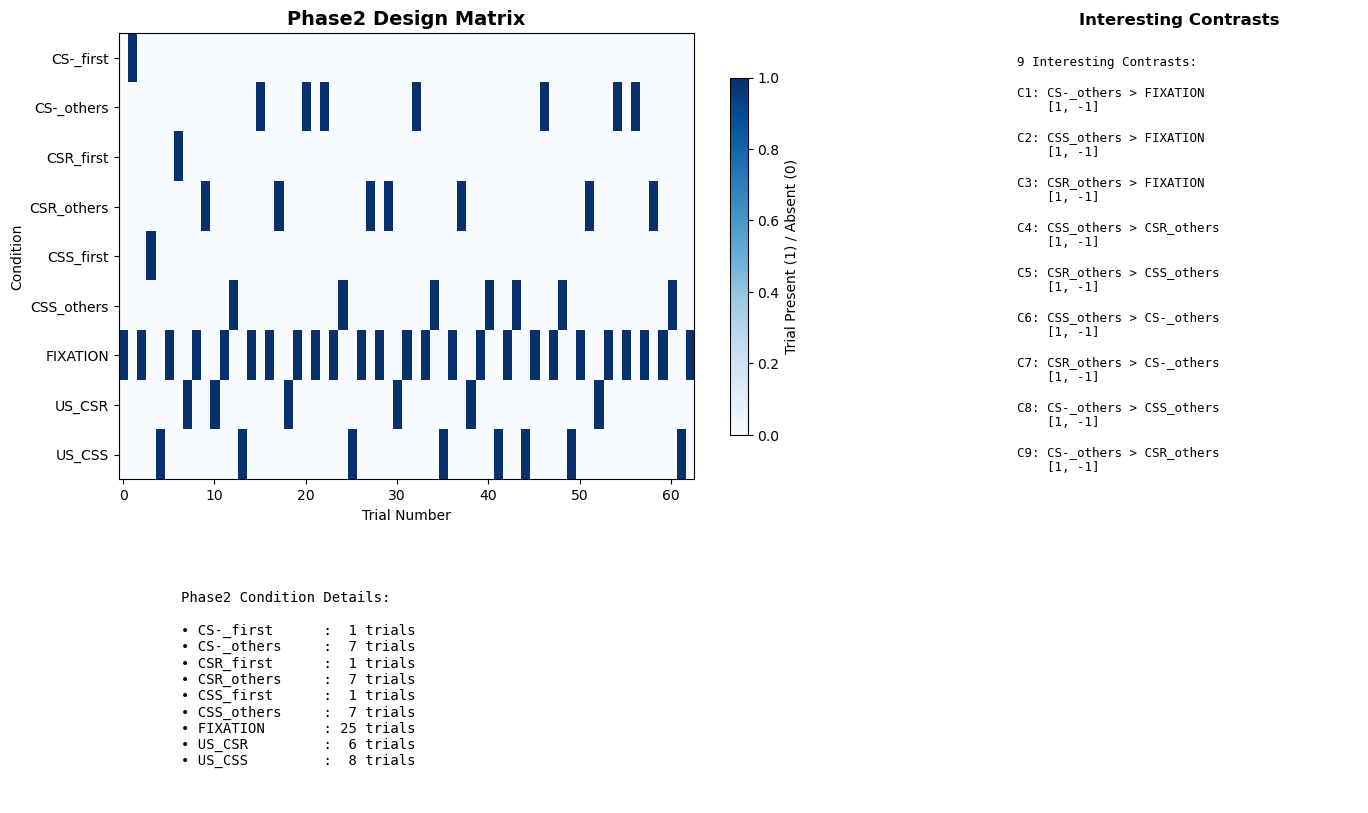


✅ PHASE2 VISUALIZATION COMPLETE!
✅ Design matrix shows 9 conditions
✅ Generated 9 interesting contrasts


In [83]:
# Phase2 Design Matrix Visualization
print("=" * 60)
print("PHASE2 DESIGN MATRIX VISUALIZATION")
print("=" * 60)

# Process phase2 data
df_phase2_conditions, _, _, _, _ = extract_cs_conditions(phase2_trial_info)
contrasts_phase2, _, _, _, _ = create_interesting_contrasts(phase2_trial_info)

# Create visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Get unique conditions and create design matrix
unique_conditions = sorted(df_phase2_conditions['conditions'].unique())
n_conditions = len(unique_conditions)

# Create design matrix representation
design_matrix = np.zeros((len(df_phase2_conditions), n_conditions))
for i, condition in enumerate(unique_conditions):
    trial_indices = df_phase2_conditions[df_phase2_conditions['conditions'] == condition].index
    design_matrix[trial_indices, i] = 1

# Main design matrix plot
ax_main = fig.add_subplot(gs[0, 0])
im = ax_main.imshow(design_matrix.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax_main.set_xlabel('Trial Number')
ax_main.set_ylabel('Condition')
ax_main.set_title('Phase2 Design Matrix', fontsize=14, fontweight='bold')

# Set y-axis labels
ax_main.set_yticks(range(n_conditions))
ax_main.set_yticklabels(unique_conditions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_main, shrink=0.8)
cbar.set_label('Trial Present (1) / Absent (0)', fontsize=10)

# Right panel - Contrast information
ax_contrasts = fig.add_subplot(gs[0, 1])
ax_contrasts.axis('off')

# Show the 9 interesting contrasts
contrast_text = "9 Interesting Contrasts:\n\n"
for i, contrast in enumerate(contrasts_phase2, 1):
    contrast_text += f"C{i}: {contrast[0]}\n"
    contrast_text += f"    {contrast[3]}\n\n"

ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                 fontsize=9, verticalalignment='top', fontfamily='monospace')
ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')

# Bottom panel - Condition details
ax_details = fig.add_subplot(gs[1, :])
ax_details.axis('off')

# Create condition details table
condition_counts = df_phase2_conditions['conditions'].value_counts()
details_text = "Phase2 Condition Details:\n\n"
for condition in unique_conditions:
    count = condition_counts[condition]
    details_text += f"• {condition:<15}: {count:2d} trials\n"

ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print(f"\n✅ PHASE2 VISUALIZATION COMPLETE!")
print(f"✅ Design matrix shows {n_conditions} conditions")
print(f"✅ Generated {len(contrasts_phase2)} interesting contrasts")


## Phase3 Design Matrix Visualization

Visualize the design matrix for Phase3 data


INFO:__main__:Using DataFrame input with 52 trials
INFO:__main__:CS- conditions: first trial at index 4, 7 others
INFO:__main__:CSS conditions: first trial at index 6, 7 others
INFO:__main__:CSR conditions: first trial at index 8, 7 others
INFO:__main__:Unique conditions for contrast generation: ['SHOCK', 'FIXATION', 'CS-_first', 'CSS_first', 'CSR_first', 'CSS_others', 'CSR_others', 'CS-_others']
INFO:__main__:Processed conditions: CS-={'first': 'CS-_first', 'other': ['CS-_others']}, CSS={'first': 'CSS_first', 'other': ['CSS_others']}, CSR={'first': 'CSR_first', 'other': ['CSR_others']}
INFO:__main__:Other conditions: ['SHOCK', 'FIXATION']
INFO:__main__:Using DataFrame input with 52 trials
INFO:__main__:CS- conditions: first trial at index 4, 7 others
INFO:__main__:CSS conditions: first trial at index 6, 7 others
INFO:__main__:CSR conditions: first trial at index 8, 7 others
INFO:__main__:Unique conditions for contrast generation: ['SHOCK', 'FIXATION', 'CS-_first', 'CSS_first', 'CSR_fi

PHASE3 DESIGN MATRIX VISUALIZATION


/var/folders/63/3j_hstl96w58qx1sdw9czhxr0000gn/T/ipykernel_39559/2514058057.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


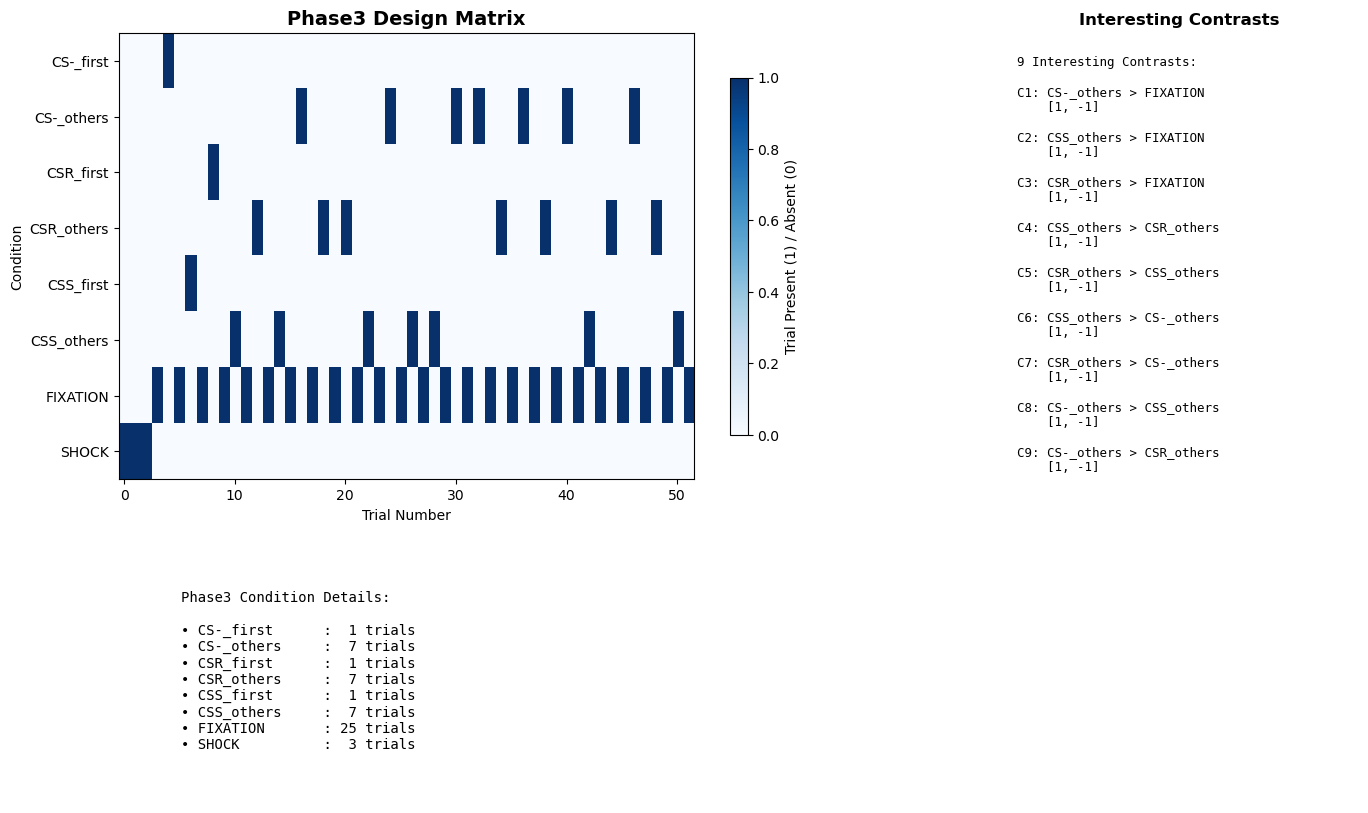


✅ PHASE3 VISUALIZATION COMPLETE!
✅ Design matrix shows 8 conditions
✅ Generated 9 interesting contrasts


In [84]:
# Phase3 Design Matrix Visualization
print("=" * 60)
print("PHASE3 DESIGN MATRIX VISUALIZATION")
print("=" * 60)

# Process phase3 data
df_phase3_conditions, _, _, _, _ = extract_cs_conditions(phase3_trial_info)
contrasts_phase3, _, _, _, _ = create_interesting_contrasts(phase3_trial_info)

# Create visualization
fig = plt.figure(figsize=(16, 10))
gs = GridSpec(2, 2, height_ratios=[2, 1], width_ratios=[2, 1], 
              hspace=0.3, wspace=0.3)

# Get unique conditions and create design matrix
unique_conditions = sorted(df_phase3_conditions['conditions'].unique())
n_conditions = len(unique_conditions)

# Create design matrix representation
design_matrix = np.zeros((len(df_phase3_conditions), n_conditions))
for i, condition in enumerate(unique_conditions):
    trial_indices = df_phase3_conditions[df_phase3_conditions['conditions'] == condition].index
    design_matrix[trial_indices, i] = 1

# Main design matrix plot
ax_main = fig.add_subplot(gs[0, 0])
im = ax_main.imshow(design_matrix.T, aspect='auto', cmap='Blues', interpolation='nearest')
ax_main.set_xlabel('Trial Number')
ax_main.set_ylabel('Condition')
ax_main.set_title('Phase3 Design Matrix', fontsize=14, fontweight='bold')

# Set y-axis labels
ax_main.set_yticks(range(n_conditions))
ax_main.set_yticklabels(unique_conditions, fontsize=10)

# Add colorbar
cbar = plt.colorbar(im, ax=ax_main, shrink=0.8)
cbar.set_label('Trial Present (1) / Absent (0)', fontsize=10)

# Right panel - Contrast information
ax_contrasts = fig.add_subplot(gs[0, 1])
ax_contrasts.axis('off')

# Show the 9 interesting contrasts
contrast_text = "9 Interesting Contrasts:\n\n"
for i, contrast in enumerate(contrasts_phase3, 1):
    contrast_text += f"C{i}: {contrast[0]}\n"
    contrast_text += f"    {contrast[3]}\n\n"

ax_contrasts.text(0.05, 0.95, contrast_text, transform=ax_contrasts.transAxes,
                 fontsize=9, verticalalignment='top', fontfamily='monospace')
ax_contrasts.set_title('Interesting Contrasts', fontsize=12, fontweight='bold')

# Bottom panel - Condition details
ax_details = fig.add_subplot(gs[1, :])
ax_details.axis('off')

# Create condition details table
condition_counts = df_phase3_conditions['conditions'].value_counts()
details_text = "Phase3 Condition Details:\n\n"
for condition in unique_conditions:
    count = condition_counts[condition]
    details_text += f"• {condition:<15}: {count:2d} trials\n"

ax_details.text(0.05, 0.95, details_text, transform=ax_details.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace')

plt.tight_layout()
plt.show()

print(f"\n✅ PHASE3 VISUALIZATION COMPLETE!")
print(f"✅ Design matrix shows {n_conditions} conditions")
print(f"✅ Generated {len(contrasts_phase3)} interesting contrasts")
